# Running inference on the Kria KV260 DPU 

#### Input images are grayscale

## Step 1: Import Required Libraries  

#### Note: The KriaKV260 notebook dosent have internet access and below are a few pre installed libraies.

In [1]:
import numpy as np
import cv2
import pickle
import os
import matplotlib.pyplot as plt
from time import time


## Define Function to Load CIFAR-10 Dataset

In [2]:
# Function to load CIFAR-10 dataset from local directory
def load_cifar10_from_directory(directory):
    def load_batch(batch_file):
        with open(batch_file, 'rb') as f:
            batch = pickle.load(f, encoding='bytes')
        images = batch[b'data']
        labels = batch[b'labels']
        return images, labels

    # Load training batches
    x_train, y_train = [], []
    for i in range(1, 6):
        batch_file = os.path.join(directory, f"data_batch_{i}")
        images, labels = load_batch(batch_file)
        x_train.append(images)
        y_train.append(labels)
    
    x_train = np.concatenate(x_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)

    # Load test batch
    x_test, y_test = load_batch(os.path.join(directory, "test_batch"))
    
    # Reshape data from flat arrays to (num_samples, 32, 32, 3)
    x_train = x_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    x_test = x_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

    # Convert x_test to grayscale
    x_test_gray = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in x_test])

    # Add a channel dimension (32,32,1)
    x_test_gray = x_test_gray[..., np.newaxis]

    return (x_train, np.array(y_train)), (x_test_gray, np.array(y_test))

## Load CIFAR-10 Dataset

In [3]:
# Specify the dataset directory path
directory = '/home/root/jupyter_notebooks/PratikEmAi2025/cifar-10-batches-py/'

# Load dataset
(x_train, y_train), (x_test, y_test) = load_cifar10_from_directory(directory)

print(f"Training samples: {x_train.shape[0]}, Test samples: {x_test.shape[0]}")

Training samples: 50000, Test samples: 10000


## Normalize Image Data

In [4]:
# Normalize images to range [0,1]
#x_train_norm = (x_train / 255.0).astype('float32')
x_test_norm = (x_test / 255.0).astype("float32")
print(f"{x_test.shape}")
print("Normalization complete.")

(10000, 32, 32, 1)
Normalization complete.


## Load DPU Overlay and Model

#### The DPU Overlay is the bit stream for the FPGA which will make it to a Deep Processing Unit. The PYNQ repository already has a default bit stream inside it, however you would need to generate your own and call it below. 

In [5]:
from pynq_dpu import DpuOverlay

# Load overlay and model on KRIA DPU
#overlay = DpuOverlay("dpu.bit") #default bitstream on your board
#overlay = DpuOverlay("<path-to-your-generated-bitstream>") 
overlay = DpuOverlay("/home/root/jupyter_notebooks/PratikEmAi2025/bitstream_generated/dpu_gen.bit") 
overlay.load_model("/home/root/jupyter_notebooks/PratikEmAi2025/bw_quant_compiled2.xmodel")
dpu = overlay.runner

print("DPU model loaded successfully.")

DPU model loaded successfully.


## Get DPU Input/Output Tensor Details

In [6]:
# Get tensor information
inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()

shapeIn = tuple(inputTensors[0].dims)
shapeOut = tuple(outputTensors[0].dims)
outputSize = int(outputTensors[0].get_data_size() / shapeIn[0])

softmax = np.empty(outputSize)

# Prepare memory buffers
output_data = [np.empty(shapeOut, dtype=np.float32, order="C")]
input_data = [np.empty(shapeIn, dtype=np.float32, order="C")]

print(f"Input shape: {shapeIn}, Output shape: {shapeOut}")


Input shape: (1, 32, 32, 1), Output shape: (1, 10)


## Define Softmax Function

In [7]:
def getSoftmax(x):
    exp_x = np.exp(x - np.max(x))  # for numerical stability
    return exp_x / exp_x.sum()


## Run Inference on a Few Sample Images

Started inference on sample images...

Image 1: Predicted class = cat (index 3)
Image 2: Predicted class = ship (index 8)
Image 3: Predicted class = truck (index 9)
Image 4: Predicted class = airplane (index 0)
Image 5: Predicted class = frog (index 6)
Image 6: Predicted class = frog (index 6)
Image 7: Predicted class = truck (index 9)
Image 8: Predicted class = frog (index 6)
Image 9: Predicted class = cat (index 3)
Image 10: Predicted class = automobile (index 1)

Completed inference.


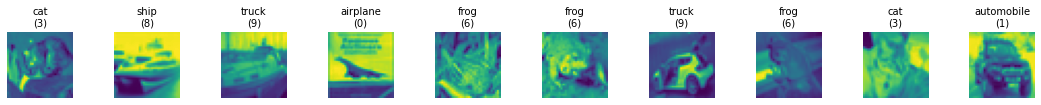

In [8]:
%matplotlib inline

# CIFAR-10 class names
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

Num_images = 10  # Number of samples to visualize
image = np.zeros((1, 32, 32, 1), dtype=np.float32)
fig, ax = plt.subplots(1, Num_images, figsize=(15, 5))
plt.tight_layout()

print("Started inference on sample images...\n")

for i in range(Num_images):
    image[0, ...] = x_test_norm[i]
    input_data = [image]
    
    # Run inference
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)

    # Apply softmax
    temp = [j.reshape(1, outputSize) for j in output_data]
    softmax = getSoftmax(temp[0][0])
    pred = softmax.argmax()

    # Get predicted class name
    class_name = class_names[pred]

    # Display image with predicted class
    ax[i].imshow(x_test[i])
    ax[i].set_title(f'{class_name}\n({pred})', fontsize=10)
    ax[i].axis('off')

    # Print results to console as well
    print(f"Image {i+1}: Predicted class = {class_name} (index {pred})")

print("\nCompleted inference.")
plt.show()



## Full Test Set Inference and Performance Metrics

In [9]:
N = x_test_norm.shape[0]
y_pred = np.empty_like(y_test)
image = np.zeros((1, 32, 32, 1), dtype=np.float32)
print("Started full DPU inference...")
start = time()


for i in range(N):
    image[0, ...] = x_test_norm[i]
    input_data = [image]
    
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    
    temp = [j.reshape(1, outputSize) for j in output_data]
    softmax = getSoftmax(temp[0][0])
    y_pred[i] = softmax.argmax()

stop = time()
print("Inference complete.")

Started full DPU inference...
Inference complete.


## Evaluate Accuracy and Throughput

In [11]:
correct = np.sum(y_pred == y_test)
acc = (correct / N) * 100
exec_time = stop - start
fps = N / exec_time

print(f"Accuracy: {acc:.2f}%")
print(f"Execution time: {exec_time:.2f} seconds")
print(f"Throughput: {fps:.2f} FPS")

Accuracy: 69.12%
Execution time: 4.76 seconds
Throughput: 2100.21 FPS


## Clean Up Resources

In [12]:
del overlay
del dpu
print("Released DPU resources.")

Released DPU resources.
